In [88]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from statsmodels.graphics.mosaicplot import mosaic
from pylab import rcParams

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *


# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [3]:
# Read in csv and create arrays
users_train_raw = pd.read_csv('../zip_files/train_users_2.csv.zip')
sessions_raw = pd.read_csv('../zip_files/sessions.csv.zip')
demographics = pd.read_csv('../zip_files/age_gender_bkts.csv.zip')
countries = pd.read_csv('../zip_files/countries.csv.zip')
test = pd.read_csv('../zip_files/test_users.csv.zip')

In [4]:
# Shuffle data
np.random.seed(0)
shuffle = np.random.permutation(np.arange(users_train_raw.shape[0]))
len(shuffle)
x = users_train_raw.reindex(shuffle)

# encode all values in numbers 
y = pd.DataFrame()
for column in list(x):
    y[column] = pd.factorize(x[column], sort=True)[0]

# split out labels from data frame
data, labels = preprocessing.normalize(np.asarray(y)[:,:-1]), np.asarray(y)[:,-1]

# Split into train and dev.
dev_data, dev_labels = data[:25000], labels[:25000]
train_data, train_labels = data[25000:], labels[25000:]

/Users/divyas/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [5]:
train = pd.read_csv('../train_dev_data/train_data.csv')
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,g936neasyy,2013-05-12,20130512210934,2013-05-13,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Mac Desktop,Chrome,other
1,duq2vabpp2,2013-03-02,20130302054534,NaN,FEMALE,31.0,facebook,0,en,direct,direct,untracked,Web,iPad,Mobile Safari,NDF
2,xiymwcsklc,2011-05-17,20110517211429,NaN,-unknown-,105.0,facebook,2,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
3,8kkcksa0dw,2013-12-02,20131202180650,2013-12-11,-unknown-,37.0,basic,0,en,sem-brand,google,omg,Web,iPad,Mobile Safari,US
4,zk8qx61d9m,2013-11-07,20131107183734,NaN,FEMALE,25.0,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF


In [6]:
dev = pd.read_csv('../train_dev_data/dev_data.csv')
#dev.head()

In [7]:
#columns_of_interest = ['language', 'gender', 'signup_method']
columns_of_interest = ['signup_method']

#creating new dataframe from train with integer values for categorical variables
#only including columns / variables of interest
train_dummy = pd.get_dummies(train[['signup_method']], columns=columns_of_interest)
dev_dummy = pd.get_dummies(dev[['signup_method']], columns=columns_of_interest)

In [8]:
train_dummy.head()

,signup_method_basic,signup_method_facebook,signup_method_google
0,1,0,0
1,0,1,0
2,0,1,0
3,1,0,0
4,1,0,0


## Looking at Variables Individually 

##### Variable: 'Age'

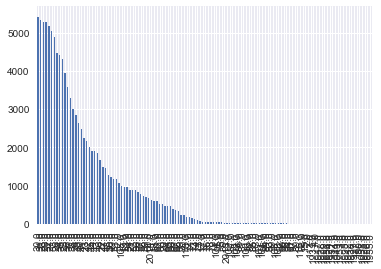

In [30]:
train.age.value_counts().plot(kind='bar')

It seems that the 'age' was not necessarily recorded as a number between 0-125 (extreme values included). 
The bar graph below shows ages appropriately binned.

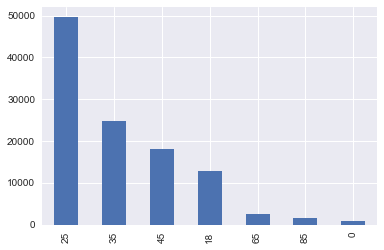

In [35]:
train.age.value_counts(bins=[0, 18, 25, 35, 45, 65, 85, 125]).plot(kind='bar')

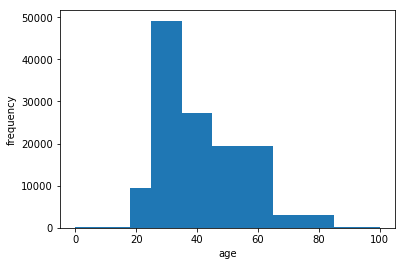

In [14]:
#drop the N/A ages
age_variable = train.age.dropna()
plt.hist(age_variable, bins=[0, 18, 25, 35, 45, 65, 85, 100])
plt.xlabel('age')
plt.ylabel('frequency')
plt.show()

In [73]:
train.age.value_counts()

30.0      5410
31.0      5317
28.0      5276
29.0      5271
32.0      5166
27.0      5040
33.0      4884
26.0      4463
34.0      4414
35.0      4303
25.0      3933
36.0      3586
37.0      3289
38.0      2998
24.0      2840
39.0      2639
40.0      2472
41.0      2235
23.0      2175
42.0      1997
45.0      1908
44.0      1894
43.0      1841
46.0      1670
22.0      1498
47.0      1460
48.0      1285
50.0      1232
49.0      1175
51.0      1172
          ... 
91.0        11
97.0        10
89.0        10
115.0       10
88.0        10
15.0         7
2.0          4
113.0        4
1931.0       3
4.0          3
1947.0       2
1928.0       2
1929.0       2
1936.0       2
1924.0       2
1932.0       2
111.0        2
1949.0       2
1953.0       1
1.0          1
1995.0       1
1942.0       1
1938.0       1
1927.0       1
132.0        1
150.0        1
1933.0       1
1925.0       1
1926.0       1
1935.0       1
Name: age, dtype: int64

The variable age has lots of entries that are invalid / unusable for the purposes of making a booking on AirBnB.

(1) Ages like 1924 are not valid.

(2) Ages <18 are not valid.

"According to Air BnB's terms and policies you must be 18 yrs old to create an account and profile."

(3) Ages like 113 (I want to say) are not valid.

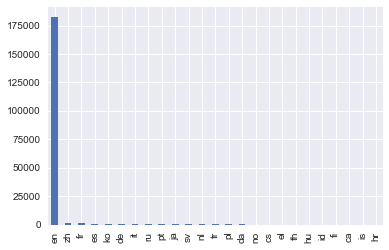

In [57]:
train.language.value_counts().plot(kind='bar')

In [58]:
train.language.value_counts()

en    182154
zh      1444
fr      1033
es       802
ko       660
de       655
it       445
ru       351
pt       201
ja       198
sv       111
nl        90
tr        57
pl        51
da        49
no        28
cs        27
el        22
th        21
hu        16
id        15
fi        11
ca         5
is         3
hr         2
Name: language, dtype: int64

An overwhelming majority of the languages used is English. The next most popular language was used almost 180 times fewer, so I doubt that language will play a reasonably important factor in predicting destination of the booking.

##### Variable: 'Sign Up App'

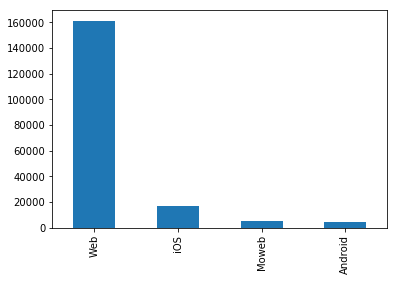

In [32]:
train.signup_app.value_counts().plot(kind='bar')

It seems that there is an overwhelming majority of sign ups that occured through the web over a mobile device or any other device.

##### Variable: 'Sign Up Method'

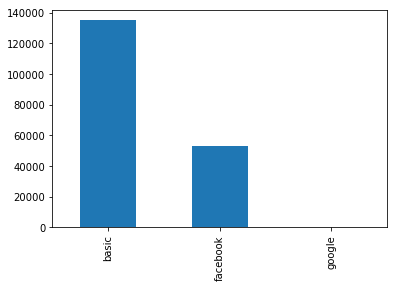

In [26]:
train.signup_method.value_counts().plot(kind='bar')

The graph depicts that there were few sign ups done through google, but a substantial amount done via facebook and in the basic airbnb account method. It may be worth our time to see if using a basic account has more of an association with a certain location (it would only be evaluating a variable with two factors).

##### Variable: 'First Device Type'

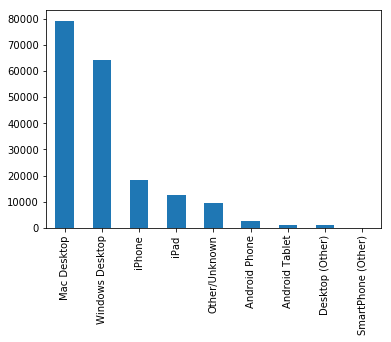

In [33]:
train.first_device_type.value_counts().plot(kind='bar')

I think there is a much cleaner distribution between first device types and this variable's potential correlation with the destination booked.

##### Variable: 'First Browser'

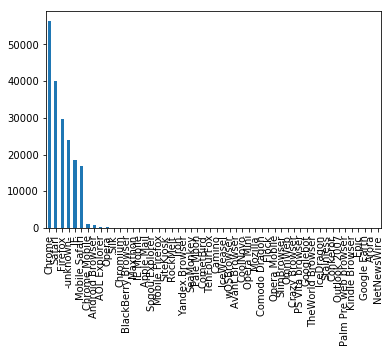

In [34]:
train.first_browser.value_counts().plot(kind='bar')

In [36]:
train.first_browser.value_counts()

Chrome                  56402
Safari                  39939
Firefox                 29698
-unknown-               24013
IE                      18632
Mobile Safari           17000
Chrome Mobile            1103
Android Browser           731
AOL Explorer              218
Opera                     166
Silk                      113
Chromium                   67
BlackBerry Browser         46
Maxthon                    35
IE Mobile                  33
Apple Mail                 32
Sogou Explorer             30
Mobile Firefox             27
SiteKiosk                  22
RockMelt                   21
Iron                       14
Yandex.Browser             11
SeaMonkey                  10
Pale Moon                  10
CometBird                  10
TenFourFox                  8
Camino                      8
IceWeasel                   7
wOSBrowser                  6
Avant Browser               4
CoolNovo                    4
Opera Mini                  3
Mozilla                     3
Comodo Dra

## # This variable should be taken into consideration to see if it has any potential effect on model accuracy (correlation with destination booking), but only the top 7 or so values.

##### Variable: 'Country Destination'

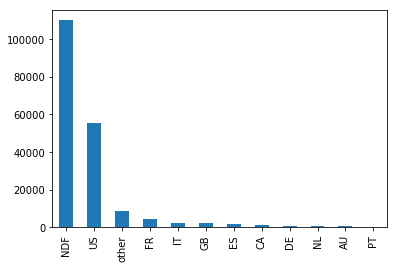

In [35]:
train.country_destination.value_counts().plot(kind='bar')

The category with the highest frequency for destinations booked is NDF.

##### Variable: 'Date Account Created'

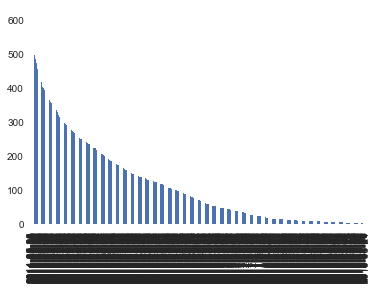

In [37]:
train.date_account_created.value_counts().plot(kind='bar')

It would be more beneficial to group the date these accounts were created by month, for example. Though this is not as helpful as the month the booking was made, maybe in combination with the sessions data, it can be a good indicator of the destination booked.

In [47]:
train['date'] = pd.to_datetime(train['date_account_created'])

In [54]:
train['month_account_created'] = train['date'].apply(lambda x: x.strftime('%B')) 

In [55]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,date,mnth_yr,month_account_created
0,g936neasyy,2013-05-12,20130512210934,2013-05-13,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Mac Desktop,Chrome,other,2013-05-12,May,May
1,duq2vabpp2,2013-03-02,20130302054534,NaN,FEMALE,31.0,facebook,0,en,direct,direct,untracked,Web,iPad,Mobile Safari,NDF,2013-03-02,March,March
2,xiymwcsklc,2011-05-17,20110517211429,NaN,-unknown-,105.0,facebook,2,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,2011-05-17,May,May
3,8kkcksa0dw,2013-12-02,20131202180650,2013-12-11,-unknown-,37.0,basic,0,en,sem-brand,google,omg,Web,iPad,Mobile Safari,US,2013-12-02,December,December
4,zk8qx61d9m,2013-11-07,20131107183734,NaN,FEMALE,25.0,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,2013-11-07,November,November


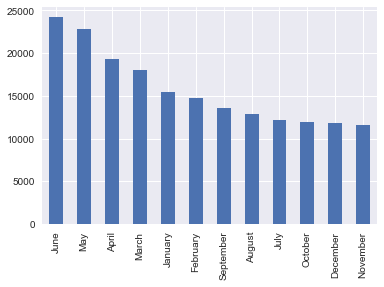

In [56]:
train.month_account_created.value_counts().plot(kind='bar')

In [75]:
train.signup_flow.value_counts()

0     145486
25     12935
12      8265
3       7780
2       6074
24      3784
23      2506
1        907
6        265
8        203
21       178
5         35
20        12
16         9
15         9
10         2
4          1
Name: signup_flow, dtype: int64

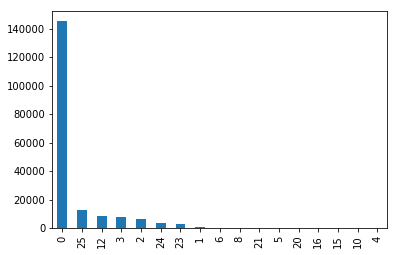

In [18]:
train.signup_flow.value_counts().plot(kind='bar')

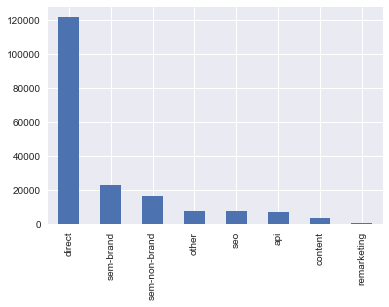

In [76]:
train.affiliate_channel.value_counts().plot(kind='bar')

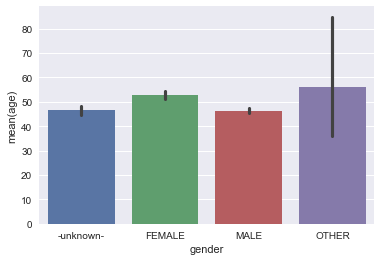

In [27]:
sns.barplot(x="gender", y="age", data=train);

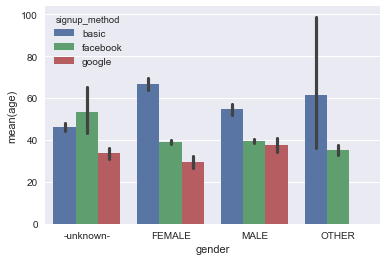

In [61]:
sns.barplot(x="gender", y = 'age', hue="signup_method", data=train);

http://seaborn.pydata.org/tutorial/categorical.html

#### train.month_account_created.value_counts()

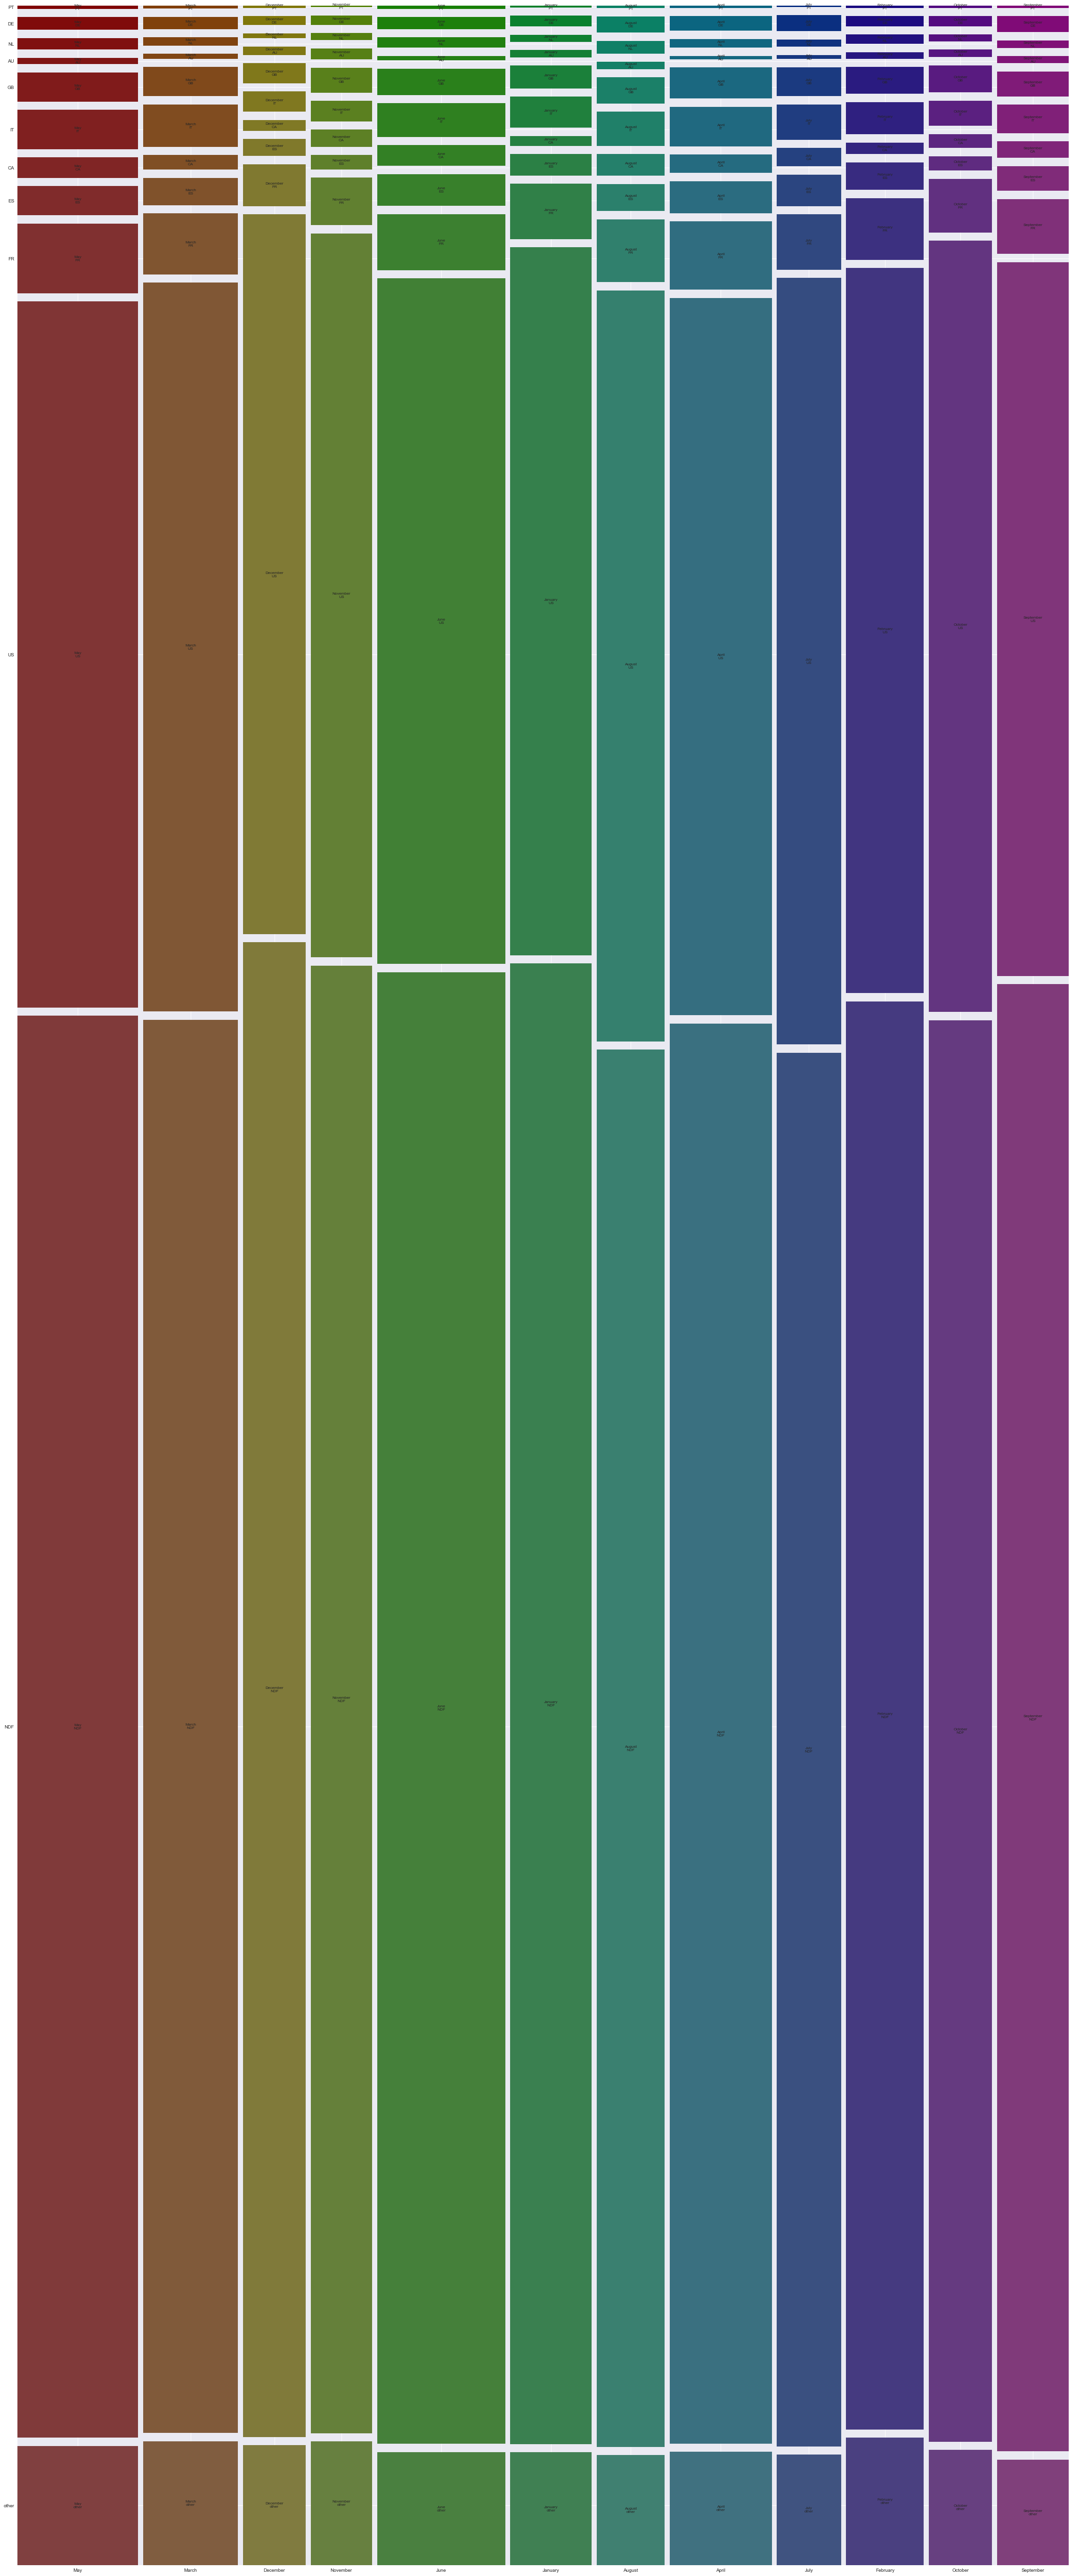

In [95]:
plt.rcParams['font.size'] = 10.0
mosaic(train, ['month_account_created', 'country_destination']);
rcParams['figure.figsize'] = 40, 100

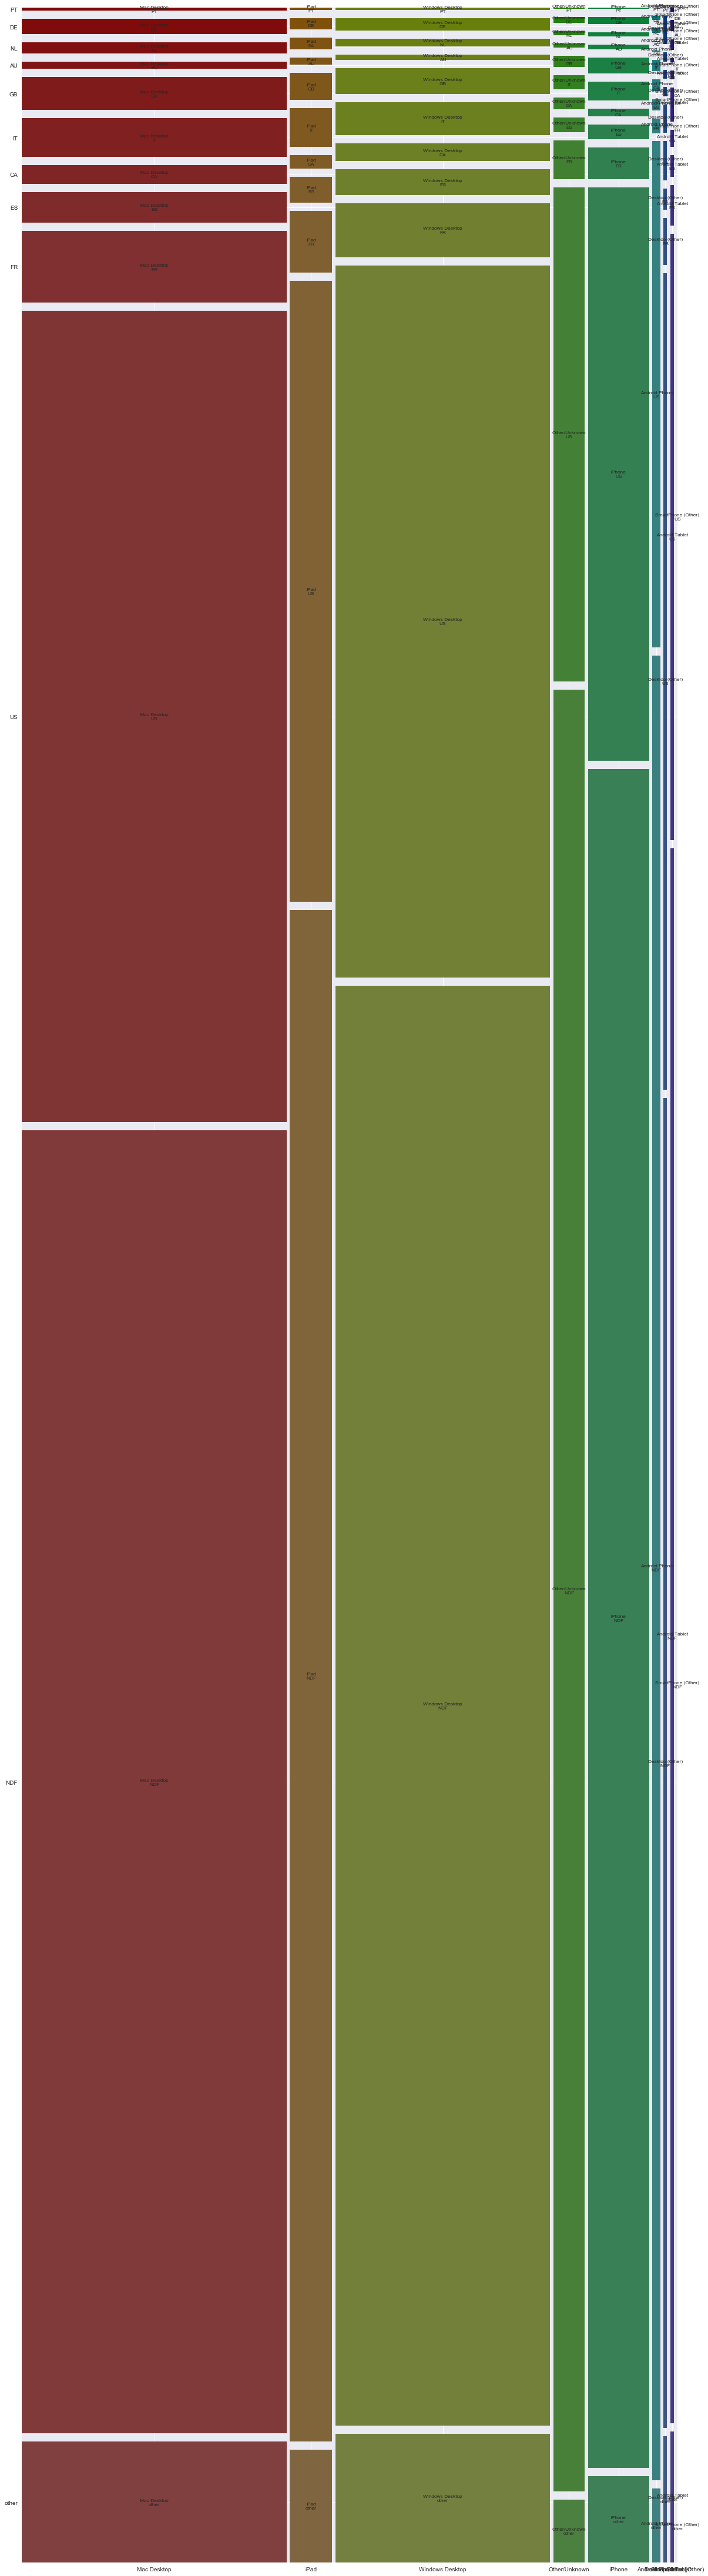

In [99]:
plt.rcParams['font.size'] = 10.0
mosaic(train, ['first_device_type', 'country_destination']);
rcParams['figure.figsize'] = 20, 80
rcParams.update({'font.size': 32})